# Проект " Выбор стратегии для взаимодействия с клиентами для сети фитнес-центров "

## 1.Загрузка и изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
try:
    data = pd.read_csv('/Users/anastasia/Desktop/gym_churn.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Набор данных включает следующие поля:
* 'Churn' — факт оттока в текущем месяце;

1. Данные клиента за предыдущий до проверки факта оттока месяц:
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [4]:
#приводим к нижнему регистру названия столбцов
data.columns = data.columns.str.lower()

## 2.Исследовательский анализ данных (EDA)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
data.duplicated().sum()

0

In [7]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000



1. Нет пропущенных значений;
2. Нет дубликатов в данных;
3. Есть дамми-переменные, но уже в исходной выборке они имеют удобную для дальнейшего анализа структуру;
4. По стандартному отклонению можно понять, что данные достаточно сильно разбросаны по большинству переменных.


In [8]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


После визуального изучения различий хочется сделать некоторые предположения:
1. пол человека никаки не влияет на попадание в отток;
2. сотрудники из компании-партнеров, вероятно, реже перестают ходить в спортзал (здесь скорее всего кроется хорошая скидка);
3. сильные различия в средних значениях видим в длительности, т.е. в основном в отток попадают клиенты, проходившие менее трех месяцев в среднем;
4. срок до окончания текущего действующего абонемента- в этой переменной также наблюдается большая разница, но можно предположить, что люди, которые попадают в отток изначально покупали абонемент на более короткий период, в то время как, если клиент купил длительный абонемент (например, год) он подошел к своему решению более сознательно и не попадает в отток;
5. разница в частоте посещений также очевидна: те, кто попадают в отток, в среднем посещают зал в два раза реже.

In [9]:
#создаем функцию для построения гистограмм с заданными параметрами
def graph_bar(data1, x):
    plt.figure(figsize=(8, 5))
    plot = sns.histplot(data=data1, x=x)
    sns.set(context='paper', style='white', palette = sns.color_palette("Set2"))
    plt.title('Распределение переменной {}'.format(x.name), fontsize=20)
    plt.ylabel('Количество', fontsize=14)
    plt.xlabel('{}'.format(x.name), fontsize=14)
    return plot

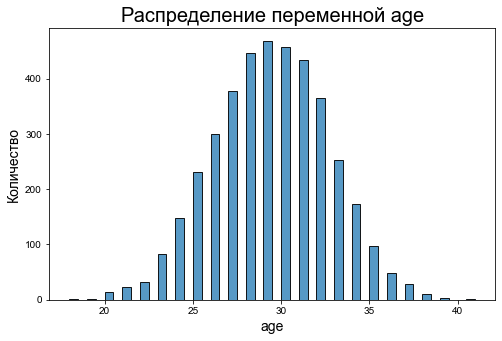

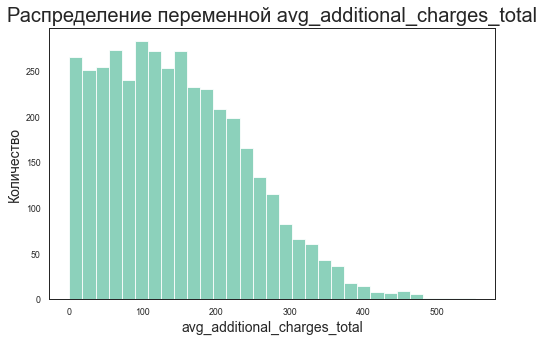

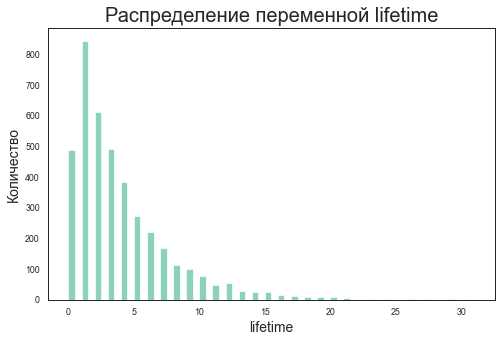

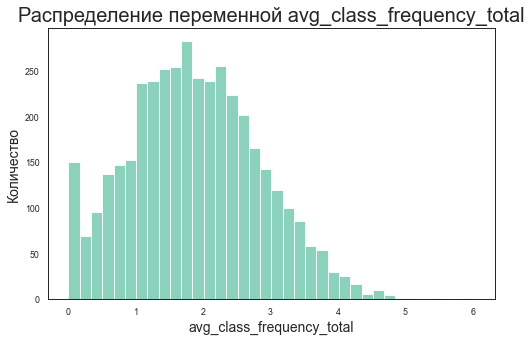

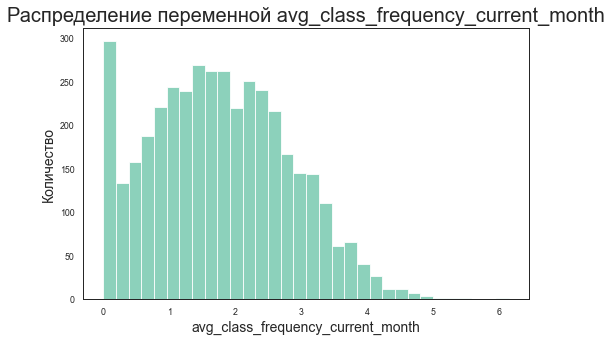

In [10]:
list =['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total',\
       'avg_class_frequency_current_month']

for i in list:
    graph_bar(data, data[i])

Построили гистограммы для некатегориальных переменных, для распределения категориальных переменных далее построим график с усами.

Вывод по распределениям численных переменных:
1. распределение переменной возраста близко к нормальному;
2. суммарная выручка от других услуг - распределение скошено вправо;
3. время с момента первого обращения в фитнес-центр - распределение переменной так же скошено вправо; 
4. средняя частота посещений в неделю - распределение близко к нормальному, но тем не менее большое число мелких значений двигают распределение вправо;
5. средняя частота посещений в неделю за предыдущий месяц - здесь сразу видим вероятно выброс, а так распределение скошено вправо.

Таким образом, большинство числовых переменных имеют скошенность вправо - большое число мелких значений в данных.Безусловно в дальнейшем необходима нормировка и стандартизация выборки.

In [11]:
#создаем функцию для построения распределения для качественных переменных с заданными параметрами
def graph_violinplot(data, x):
    plt.figure(figsize=(8, 5))
    ax = sns.violinplot(y=x, data=data, palette='rainbow')
    #sns.set(context='paper', style='white', palette = sns.color_palette("Set2"))
    plt.title('Распределение переменной {}'.format(x.name), fontsize=20)
    plt.ylabel('Количество', fontsize=14)
    plt.xlabel('{}'.format(x.name), fontsize=14)
    return ax

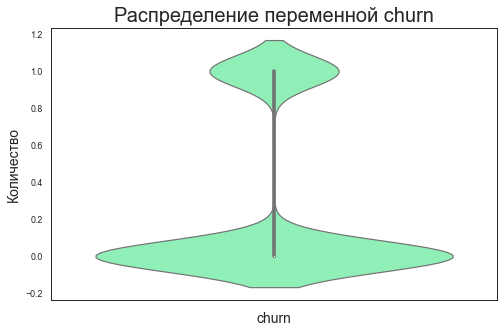

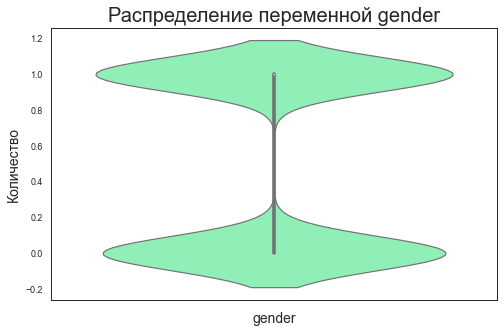

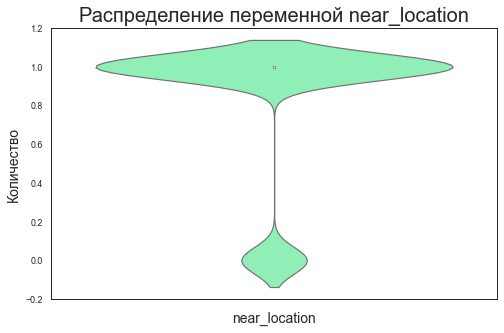

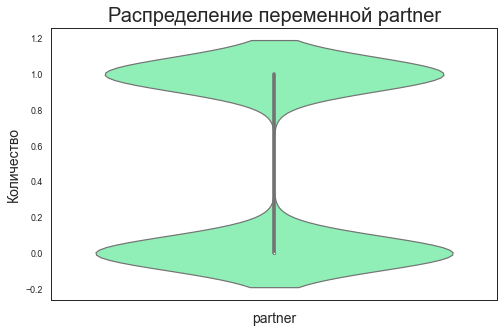

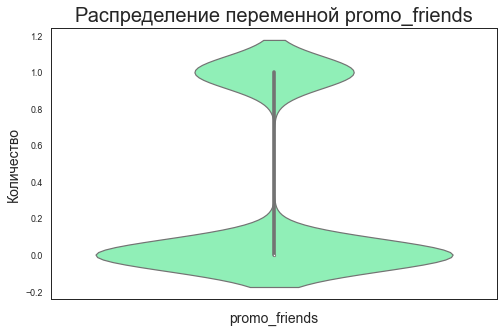

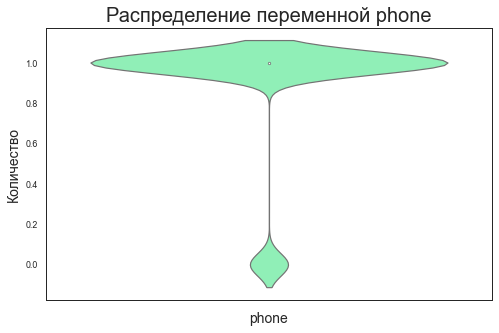

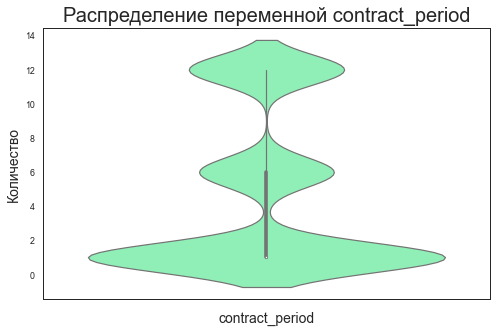

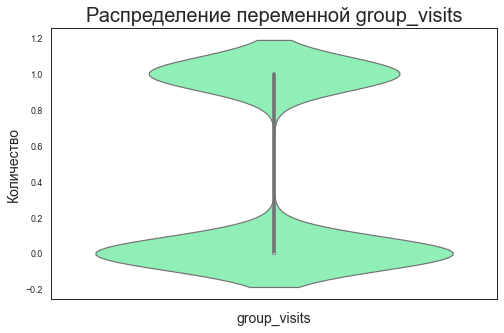

In [12]:
list_category =['churn','gender', 'near_location', 'partner', 'promo_friends',\
       'phone', 'contract_period', 'group_visits']

for i in list_category:
    graph_violinplot(data, data[i])

In [13]:
#создаем функцию для построения ящика с усами для количественных переменных с заданными параметрами
def graph_boxplot(data, x):
    plt.figure(figsize=(7, 5))
    ax = sns.boxplot(y=x, data=data, palette=sns.color_palette("PuBu", 10))
    #sns.set(context='paper', style='white', palette = sns.color_palette("Set2"))
    plt.title('Распределение переменной {}'.format(x.name), fontsize=20)
    plt.ylabel('Количество', fontsize=14)
    plt.xlabel('{}'.format(x.name), fontsize=14)
    return ax

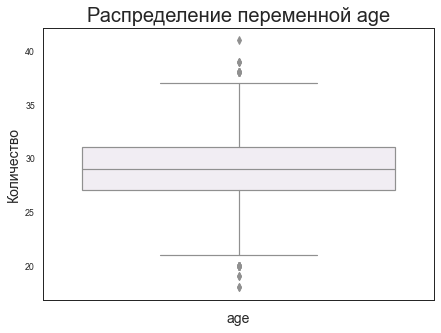

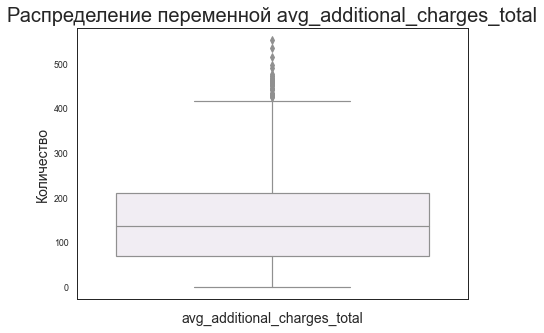

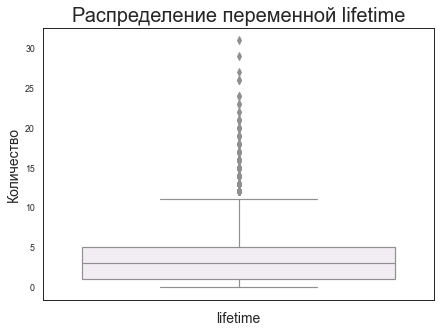

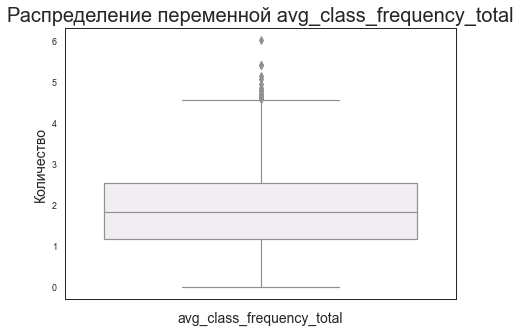

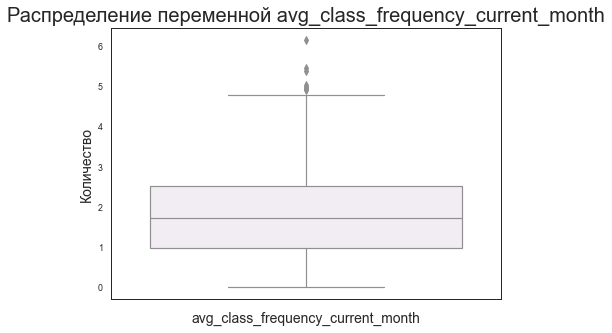

In [14]:
list =['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total',\
       'avg_class_frequency_current_month']

for i in list:
    graph_boxplot(data, data[i])

Вывод по гистограммам:
1. Скрипичные графики не особо информативны, впрочем как и ящики с усами в данном случае для категориальных перемнных, по ним мы можем только понять, как соотносятся категории:
* По полу выборки практически равны;
* По близости локаций в основном преобладает 1 - то есть близкое расположение;
* Парнет и не партнер имеют практически одинаковое соотношение;
* Большинство не были клиентами по акции "приведи друга";
* Основная выборка на данный момент находится на первональном этапе своего абонемента;
* Большинсвто выборки не посещает групповые занятия;
* И последнее, на что стоит обратить внимание - на зависимую переменную - здесь **неравные классы!!!** Большая часть выборки - не отток.
2. Теперь рассмотрим ящики с усами для количественных переменных:
* Возраст - по ящику с усами также видно, что медиана находится приблизительно посередине распределения, выбросы есть, но их немного (выбросы есть как в больших значениях, так и в маленьких);
* Медиана меньше среднего значения, много выбросов;
* Медиана располагается близко к небольшим значениям, 75% выборки не принимают значения приблизительно выше 12;
* Также нельзя назвать распределение нормальным, медиана стремится к меньшим значениям; присутствует немного выбросов;
* Значение близко к нормальному, но тем не менее медиана меньше среднего, выбросов мало.

Теперь посмотрим, как отличаются распределения переменных в сравнении между двумя группами (отток и не отток).

In [15]:
#функция для построения гистограммы для сравнения двух выборок
def hist(data1, data2, x):
    plt.hist(data1[x], alpha = 0.8, label = 'churn_yes')
    plt.hist(data2[x], alpha = 0.5, label = 'churn_no')
    plt.legend(loc='upper left')

In [16]:
churn_yes = data[data['churn'] == 1]
churn_no = data[data['churn'] == 0]

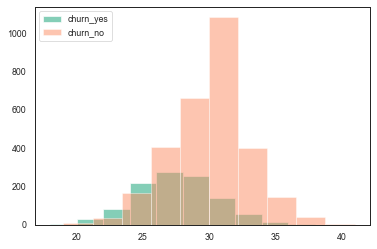

In [17]:
hist(churn_yes, churn_no, 'age')

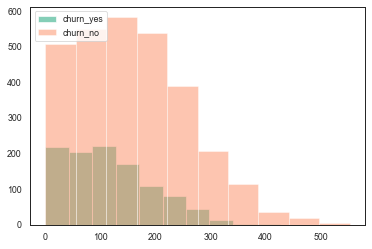

In [18]:
hist(churn_yes, churn_no, 'avg_additional_charges_total')

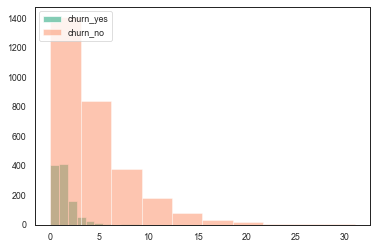

In [19]:
hist(churn_yes, churn_no, 'lifetime')

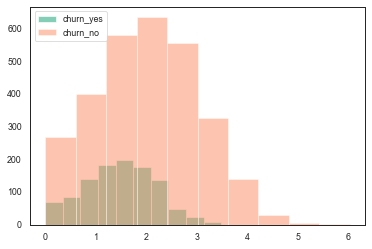

In [20]:
hist(churn_yes, churn_no, 'avg_class_frequency_total')

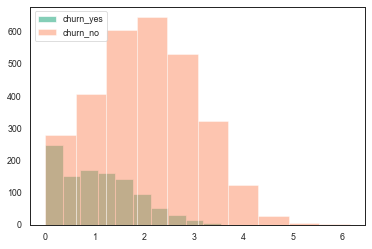

In [21]:
hist(churn_yes, churn_no, 'avg_class_frequency_current_month')

Вывод:
1. Возраст - видим, что среди клиентов, которые попали в отток, основная возрастная категория - это 25-30 лет,и остальные не превышают приблизительно 37 лет;
2. Суммарная выручка от клиентов из оотока значительно меньше;
3. Продолжительность использования абонемента не превышает 5 месяцев;
4. Средняя частота посещений занятий в неделю за все время абонемента не превышает в среднем 2 раза и по кол-ву в 3 раза меньше чем у клиентов, не попавших в отток;
5. Средняя частота посещений в неделю за предыдущий месяц в большинстве вообще не превышает 1 раза.

В целом достаточно сильно аномальных значений в ходе исследовательского анализа мы не встретили, поэтому пока можем оставить выборку в исходном состоянии.

Теперь необходимо посмотреть на корреляцию между зависимой и независимыми переменными, а также между независимыми.

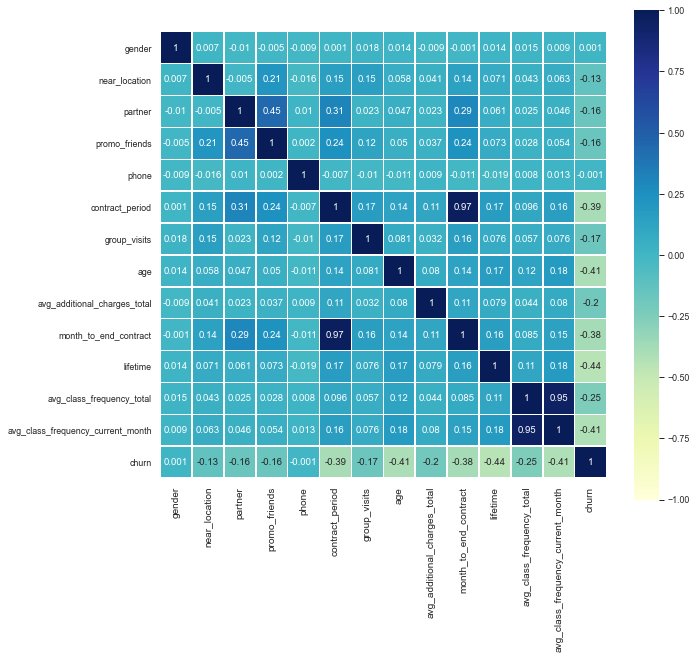

In [22]:
correlation_matrix = data.corr().round(3)
plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot = True, square = True, vmin=-1, vmax=1,linewidths=.5, cmap="YlGnBu")
plt.xticks( fontsize = 10);

Вывод к матрице корреляций:
1. Сначала обсудим независимые переменные:
* наблюдаем сильную корреляцию между переменными - **длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента (в месяцах)**; естественно мы не можем оставить эти две переменные в моделе, поэтому от одной из них придется отказаться;
* также сильная корреляция между - **средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц**; это логично, поскольку данные переменные тоже сильно схожи; 
* корреляция остальных переменных не вызывает вопросов;
2. Теперь перейдем к корреляции между независимыми и зависимой переменной:
* практически у всех переменных (за исключением пола) **связь отрицательная**;
* связь большинства переменных можно охарактеризовать **слабой и средней силы**;
* **наличие номера телефона и выручка от других услуг фитнес-зала имеют наименьшую корреляцию с зависимой переменной**, но это не означает, что в дальнейшем в моделе их не стоит использовать, поскольку маловероятно, но вдруг у них есть нелинейная связь.

Перед моделированием нам необходимо избавиться от двух столбцов, чтобы в дальнейшем избежать проблемы мультиколлинеарности. Удалим переменные - срок до окончания текущего действующего абонемента (выбрали этот поскольку в паре с другим они взаимоисключащие и откинув эту переменную мы не потеряем никакой ценной информации); и удалим - средняя частота посещений в неделю за все время с начала действия абонемента , поскольку с помощью информации о последнем месяце вероятнее мы сможем более детально отследить тот момент, когда клиенту надоедает посещение зала.

In [23]:
data_new = data.drop(['contract_period', 'avg_class_frequency_total'], axis = 1)
data_new.head()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.000000,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.910244,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.736502,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.120078,0


На основе проведенного анализа можно выдвинуть несколько гипотез:
1. Пол не влияет на отток клиентов;
2. Чем больше возраст клиента, тем меньше вероятность, что он перестанет ходить в спортза;
3. Чем дольше клиент использует свой абонемент, тем меньше вероятность, что он покинет фитнес-зал;
4. Частое посещение спортзала снижает вероятность попадания клиента в отток;
5. Если сотрудник из компании-партнера фитнесс-зала, то вероятнее всего, он меньше подвержен желанию не ходить именно в этот спортзал;
6. Посещение групповых тренировок также могут стимулироватт клиента не покилать спортзал;
7. Клиенты, пришедшие по программе " приведи друга" (вероятно всего получают скидку), поэтому используют свои абонементы и с меньшей вероятностью покидают фитнесс-зал.

## 3. Модель прогнозирования оттока клиентов

Поскольку из гистограмм распределений мы видели, что данные наши по больше части не имеют нормального распределение (основная часть скошена вправа), то перед построением модели нам просто необходимо стандартизация данных.

In [24]:
y = data_new['churn']
x = data_new.drop(['churn'], axis = 1)

In [25]:
#проводим стандартизацию; выборку поделим стандартным способом 80:20 временных зависимостей здесь нет
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)
scaler = StandardScaler()
x_train_st = scaler.fit_transform(X_train)
x_test_st = scaler.transform(X_test)

In [26]:
#логистическая регрессия
logistic_regression = LogisticRegression(solver='liblinear', random_state=0)
logistic_regression.fit(x_train_st, y_train)
predictions_lr = logistic_regression.predict(x_test_st)
probabilities_lr = logistic_regression.predict_proba(x_test_st)[:,1]

In [27]:
#случайный лес
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 0)
random_forest.fit(x_train_st, y_train)
predictions_rf = random_forest.predict(x_test_st)
probabilities_rf = random_forest.predict_proba(x_test_st)[:,1]

In [28]:
#создадим функцию, которая выводит метрики для разных моделей
def print_all_metrics(y, predictions,title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y, predictions)))
    print('\tF1: {:.2f}'.format(f1_score(y, predictions)))

In [29]:
#логистическая регрессия
print_all_metrics(y_test,predictions_lr)

Метрики классификации
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81


In [30]:
#случайный лес
print_all_metrics(y_test,predictions_rf)

Метрики классификации
	Accuracy: 0.91
	Precision: 0.82
	Recall: 0.78
	F1: 0.80


Вывод:
1. Метрика accuracy здесь будет бесполезна, поскольку у нас неравные классы в зависимой переменной;
2. Precision немного выше у модели случайного леса, т.е. она точнее в распознавании positive объектах;
3. Recall наоборот выше у модели логистической регрессии, т.е. алгоритм больше находит положительных объектов из всех имеющихся в ввыборке;

Резюмируя:
* Логистическая регрессия определяет большинство Positive семплов, но имеет больше ложных срабатываний;
* Случайный лес - делает достаточно точно предсказания, определяя класс Positive, но производит меньше таких прогнозов.

Для нас вероятно меньшими потерями будет то, что мы примем обычного клиента за того, кто собирается уходить, поэтому лучше сделать выбор в пользу метрики precision и получить больше ложно-позитивных значений.

Вывод: таким образом, получается, что мы делаем выбор в пользу логистической регрессии.

## 4. Кластеризация клиентов

In [31]:
#убираем из датасета зависимую переменную
data_cluster = data_new.drop('churn', axis =1)

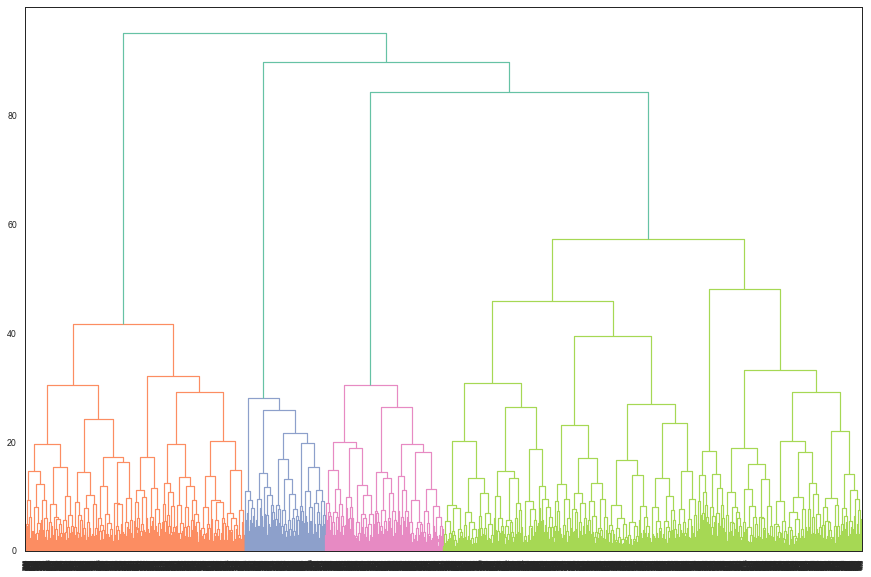

In [32]:
#стандартизируем датасет и строим дендрограмму
sc = StandardScaler()
x_sc = sc.fit_transform(data_cluster)

linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Вывод:
После изучения дендрограммы логичнее всего отрезать дендрограмму по K =60 и поделить выборку на 3 кластера. 

In [33]:
#модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

data_cluster['cluster_km'] = labels

In [34]:
# выводим статистику по средним значениям наших признаков по кластеру
data_cluster.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,0.528000,29.633000,154.086252,6.730000,4.287000,1.919105
1,0.495352,0.998672,0.378486,0.046481,0.903054,0.000000,30.342629,174.392898,4.698539,5.166003,2.237272
2,0.511194,1.000000,0.226368,0.114428,0.899254,0.182836,26.807214,111.073289,1.715174,1.420398,0.978977
3,0.502455,0.000000,0.489362,0.072013,0.913257,0.232406,28.700491,137.375245,2.826514,3.027823,1.599583
4,0.550481,0.998798,0.274038,0.075721,0.897837,1.000000,30.248798,155.206260,4.707933,4.483173,2.043261


Сделаем некоторые предварительные выводы исходя из средних значений по кластерам:
1. 0 кластер отличается от остальных: практически все клиенты пришли по акции "приведи друга"; у клиентов из этой группы осталось больше всего (по сравнению с другими кластерами) месяцев до окончания абонемента;
2. 1 кластер: клиенты не посещают групповые занятия и оставляют самые высокие чеки на доп.услуги в спортзале;в среднем в данном кластере люди более старшего возраста;
3. 2 кластер: спортза располагается рядом у всех клиентов; основная часть не пришли по акции " приведи друга"; низкая частота посещений занятий;
4. 3 кластер отличается: спортзал не располагается близко к клиенту; в остальных показателях занимает средние позиции;
5. 4 кластер: все клиенты посещают групповые занятия; средний возраст клиентов выше 30;за последний месяц посещает спортзал 2 раза в неделю в среднем.
    

In [35]:
def graph_boxplot(data, y):
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(x = data['cluster_km'],y=y, data=data, palette='rainbow')
    sns.set(context='paper', style='white', palette = sns.color_palette("Set2"))
    plt.title('Распределение переменной {}'.format(y.name), fontsize=20)
    plt.ylabel('Количество', fontsize=14)
    plt.xlabel('{}'.format(y.name), fontsize=14)
    return ax

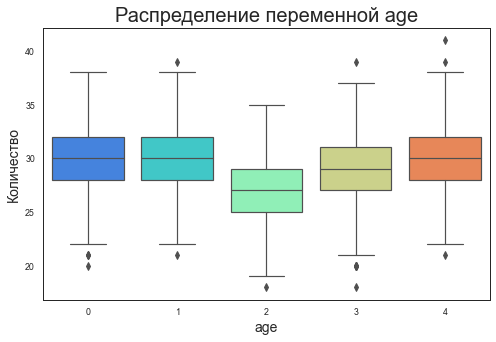

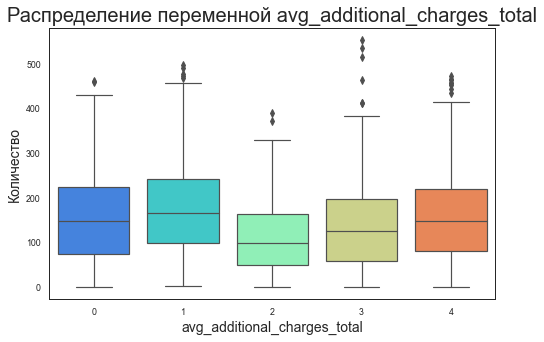

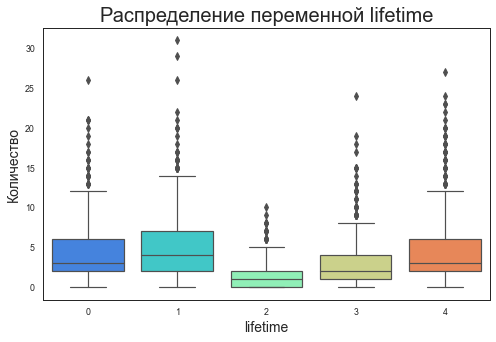

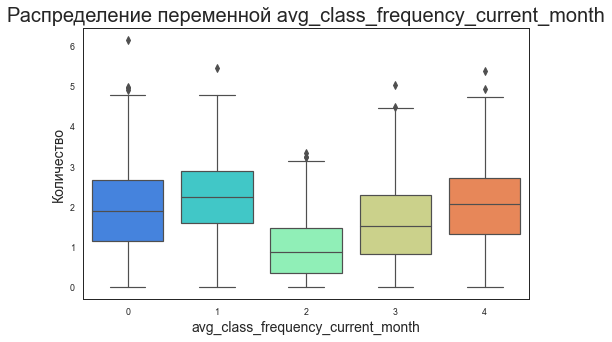

In [36]:
list =['age', 'avg_additional_charges_total', 'lifetime',\
       'avg_class_frequency_current_month']

for i in list:
    graph_boxplot(data_cluster, data_cluster[i])

In [37]:
data_new['cluster_km'] = labels

In [38]:
data_new.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.108000
1    0.046481
2    0.741294
3    0.400982
4    0.092548
Name: churn, dtype: float64

Если мы посмотрим на распределение долей в переменной "отток", то заметим, что больше всего оттоку подвержены клиентыиз кластера 2, т.е.редкое посещение спортзала (и даже близкое расположение зала непомеха), а также те, кто не воспользовался акцией "приведи друга";
Залогом того, что клиент не уйдет из спортзала является кластер 1: клиенты, как правило более старшего среднего возраст, которые не ходят на групповые занятия, но при этом оставляют достаточно много денежных средст на доп.услуги в спортзале.

## 5. Выводы и базовые рекоммендации

1. Цель - составить общий портрет клиента, попадающего в отток, и разработать стратегию взаимодействия с клиентами;
2. Данные:
* 'Churn' — факт оттока в текущем месяце;
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.
3. В качестве модели для бинарной классификации клиентов была выбрана модель логистической регрессии (по метрикам был сдела выбор в пользу recall, т.е. можем столкнуться с вероятностью ложного отнесения клиента в отток);
4. В ходе кластеризации дендрограмма явно демонстрирует разбиение выборки на 4 кластера;
5. После проведения кластеризации методом K-средних мы можем сделать следующие выводы.

Типичный портрет клиента, который не попадает в отток:
1. спортзал располагается близко к клиенту;
2. средний возраст около 30;
3. оставляется достаточно большую сумму денег на доп.услуги в спортзале;
4. изначально приобретают абонементы на более длительный срок;
5. посещают спортзал не реже 2 раз в неделю в среднем

Типичный портрет клиента, который попадает в отток:
1. большинство не посещает групповые занятия;
2. средний возраст ниже чем те, кто продолжают ходить в спортзал и в среднем около 26-28;
3. низкие затраты на доп.услуги в фитнес-центре;
4. как правильно посещают спортзал реже двух раз в неделю;
5. изначально покупают абонемент на непродолжительный срок и уже спустя 1,5-2 месяца бросают походы в спортзал.

### Рекоммендации

1. Увеличить еженедельную посещаемость - выставлять абонементы со скидкой, в случае посещения фитнес-центра не реже двух раз в неделю;
2. Предоставлять пробные индивидуальные тренировки с тренером по групповым занятиям, чтобы лучше адаптировать клиента;
3. Проводить более расширенную программу маркетинга - например, выдавать подарки из магазина фитнес-центра с целью дальнейшего приведения клиента вновь за этим товаром;
4. Снизить цену на долгосрочные абонементы;
5. Проводить акции не только для студентов или лиц старших возрастов, но и для клиентов, среднего возраста, например, от 25 до 35.